# Set-up

This experiment requires the adapted TransformerLens library which added support for the BERTForSequenceClassification architecture and automatically loading in the custom fine-tuned models from HuggingFace. It can be installed by executing the command below.

In [ ]:
!pip install git+https://github.com/andres-vs/TransformerLens.git@b0de195fa5a0f427427e142e9a7066f47bf193f9
!pip install datasets --upgrade

In [ ]:
import torch
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
THESIS_PATH = "/content/drive/MyDrive/Hoger/Master_Thesis/Attention_pattern_experiments"

# Reproducing GPT2 greaterthan results

In [ ]:
from transformer_lens import HookedTransformer

# Load the GPT-2 small model
model_name = "gpt2"
model = HookedTransformer.from_pretrained(model_name)

In [ ]:
input_text = "The war lasted from the year 1732 to the year 17"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokens = tokenizer(input_text, return_tensors='pt')


In [ ]:
attention_patterns = {}

# Hook to capture attention scores
def hook_fn(module_output, hook=None):
    attention_patterns[hook.name] = module_output.detach()

# Register the hook for the attention pattern in layer 7
model.add_hook("blocks.7.attn.hook_pattern", hook_fn)

In [ ]:
# Run the model with hooks
with model.hooks(fwd_hooks=[('blocks.7.attn.hook_pattern', hook_fn)]):
    model(tokens.input_ids)

In [ ]:
# Access the attention pattern (softmaxed attention scores)
head_attention_scores = attention_patterns["blocks.7.attn.hook_pattern"][0, 10, :, :] # [batch_size, head_index, seq_len, seq_len]

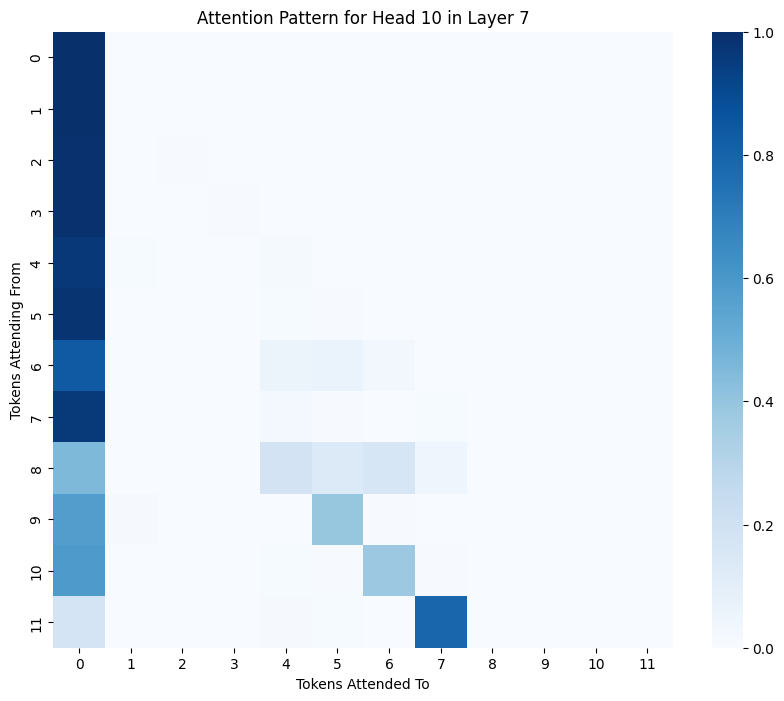

In [ ]:
# Plot the heatmap for the attention scores
plt.figure(figsize=(10, 8))
sns.heatmap(head_attention_scores.cpu().numpy(), cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Attention Pattern for Head 10 in Layer 7")
plt.xlabel("Tokens Attended To")
plt.ylabel("Tokens Attending From")
plt.show()


# Applied to BERT on textual entailment taak

## Set-up


Use your HuggingFace token to login to HuggingFace and load in the dataset and model.

In [ ]:
from huggingface_hub import login
your_hf_token = "your_hf_token_here"  # Replace with your actual Hugging Face token
login(token=your_hf_token, add_to_git_credential=True)

In [ ]:
DEPTH = 2
QDep = False
RETRAINED = False
BATCH_SIZE = 64
ALL_HEADS = True

ALL_EXAMPLES = False
PROOF_DEPTH = 2
PROOF_STRATEGY = "proof"

tokenizer_name = "bert-base-uncased"
model_name = "andres-vs/bert-base-uncased-finetuned_Att-Noneg"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
if QDep:
    dataset_name = f"andres-vs/ruletaker-Att-Noneg-QDep{DEPTH}-NoRconc"
    if RETRAINED:
        model_name = model_name + f"-QDep{DEPTH}-NoRconc_retrained"
    else:
        model_name = model_name + f"-QDep{DEPTH}-NoRconc"
else:
    dataset_name = f"andres-vs/ruletaker-Att-Noneg-depth{DEPTH}"
    if RETRAINED:
        model_name = model_name + f"-depth{DEPTH}_retrained-1"
    else:
        model_name = model_name + f"-depth{DEPTH}"

In [ ]:
print(model_name)
print(dataset_name)

## Load dataset and preprocessing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [ ]:
from datasets import load_dataset
dataset = load_dataset(dataset_name)

In [ ]:
if ALL_EXAMPLES:
    filtered_dataset = dataset['test']
else:
    # Filter the dataset
    filtered_dataset = dataset['test'].filter(lambda example: example['depth'] == PROOF_DEPTH and example['proof_strategy'] == PROOF_STRATEGY)

In [ ]:
import torch

def tokenize_function(examples):
    tokenized_output = tokenizer(examples["input"], truncation=True, padding=False)
    # Convert labels to one-hot encoding using PyTorch
    labels = torch.tensor(examples['label'], dtype=torch.int64)
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
    tokenized_output['label'] = one_hot_labels.tolist()  # Convert back to list for datasets
    return tokenized_output

In [ ]:
tokenized_dataset = filtered_dataset.map(tokenize_function, batched=True)

# Set the format of the dataset to PyTorch tensors
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label', 'token_type_ids'])

In [ ]:
from torch.utils.data import DataLoader

# Define a collate function to stack tensors
def collate_fn(batch):
    # Extract inputs
    inputs = {key: [example[key] for example in batch] for key in batch[0].keys()}

    # Use the tokenizer to pad dynamically
    padded_inputs = tokenizer.pad(
        inputs,
        padding="longest",  # Pad to the longest sequence in the batch
        return_tensors="pt",  # Return PyTorch tensors
    )
    return padded_inputs


# Create a DataLoader for batched access
dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Load in model and set up hooks

In [ ]:
from transformer_lens import HookedEncoder

# Load the model
model = HookedEncoder.from_pretrained(model_name, tokenizer=tokenizer, head_type='classification')
model.to(device)

In [ ]:
# Define a function to extract the numeric layer and head number from the string
def extract_layer_number_and_head_number(tup):
    layer_str = tup[0]
    # Extract the number between "blocks." and ".attn"
    layer_number = int(layer_str.split('.')[1])
    return layer_number, tup[1]  # Return the layer number and head number for sorting

# Define a function to extract the numeric layer from the string
def extract_layer_number(hook_name):
    # Extract the number between "blocks." and ".attn"
    layer_number = int(hook_name.split('.')[1])
    return layer_number  # Return the layer number and head number for sorting

In [ ]:
attention_patterns = {}

# Hook to capture attention scores
def hook_fn(module_output, hook=None):
    attention_patterns[extract_layer_number(hook.name)] = module_output.detach()

## Extract attention patterns

In [ ]:
prompt_number = 11
input_text = "Harry is furry. Harry is cold. Erin is furry. If Erin is furry then Erin is quiet. If something is quiet and furry then it is round.[SEP]Erin is round."
tokens = tokenizer(input_text, return_tensors='pt')

In [ ]:
# Decode the tokens into readable format
decoded_tokens = tokenizer.convert_ids_to_tokens(tokens.input_ids[0])

In [ ]:
if ALL_HEADS:
    HOOKS_TO_MONITOR_SORTED = [(f"blocks.{layer}.attn.hook_pattern", head) for head in range(12) for layer in range(12)]

In [ ]:
# Run the model with hooks
with model.hooks(fwd_hooks=[(hook_name, hook_fn) for hook_name, _ in HOOKS_TO_MONITOR_SORTED]):
    model(input=tokens.input_ids, token_type_ids=tokens.token_type_ids, one_zero_attention_mask=tokens.attention_mask)

In [ ]:
# check if the path f"{THESIS_PATH}/depth{DEPTH}_retrained/prompt-{prompt_number}/" exists and if not, create a new folder
import os

folder_path = f"{THESIS_PATH}/{model_name.split('/')[-1]}/prompt-{prompt_number}_all_heads/"

if not os.path.exists(folder_path):
  os.makedirs(folder_path)

In [ ]:
for (hook_name, head_number) in HOOKS_TO_MONITOR_SORTED:
    # Access the attention pattern (softmaxed attention weights)
    head_attention_scores = attention_patterns[extract_layer_number(hook_name)][:, head_number, :, :] # [batch_size, head_index, seq_len, seq_len]
    avg_head_attention_scores = torch.mean(head_attention_scores, dim=0)

    # Plot the heatmap for the attention scores
    plt.figure(figsize=(20, 18))
    sns.heatmap(avg_head_attention_scores.cpu().numpy(), cmap=sns.color_palette("Blues", as_cmap=True), xticklabels=decoded_tokens, yticklabels=decoded_tokens)
    plt.title(f"Attention Pattern for Head {head_number} in Layer {hook_name.split('.')[1]}")
    plt.xlabel("Tokens Attended To")
    plt.ylabel("Tokens Attending From")
    plt.savefig(f"{folder_path}/{hook_name}-head_{head_number}.png")
    plt.close()